<a href="https://colab.research.google.com/github/peteray-dev/RAG_LLM_BusinessTech/blob/master/Hybrid_Search_LLM_(RAG_%2B_Fine_Tuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Feb  1 15:11:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#  !pip install weaviate-client

In [3]:
!pip install -q "weaviate-client<4.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.1/120.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.6/225.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.5 MB/s eta 0:00:00


In [4]:
!pip install -q langchain langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.0 MB/s eta 0:00:00


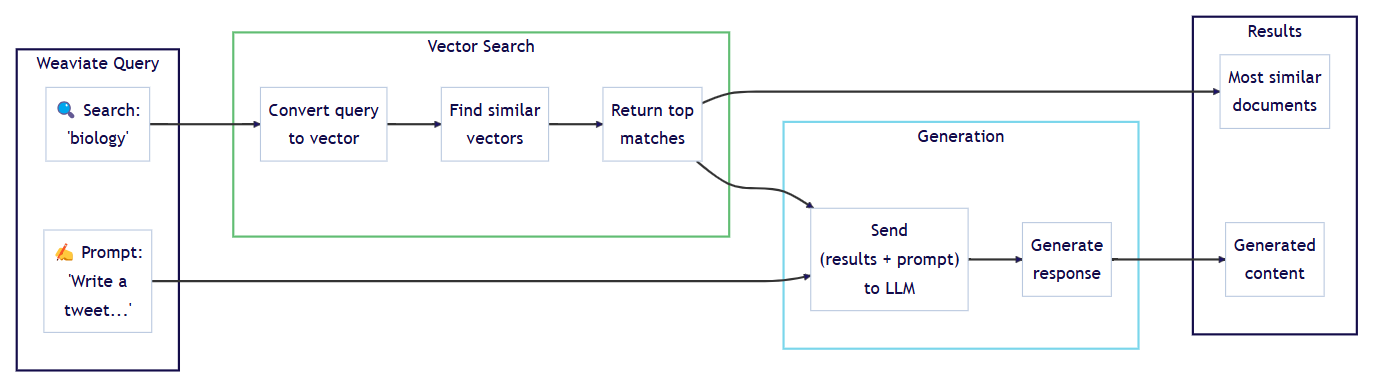

In [5]:
import weaviate
import os

In [6]:
from google.colab import userdata
WEAVIATE_CLUSTER = userdata.get('WEAVIATE_CLUSTER')
WEAVIATE_API_KEY = userdata.get('WEAVIATE_API_KEY')
HF_TOKEN = userdata.get('HF_TOKEN')

In [7]:
# print(WEAVIATE_CLUSTER)
# print(WEAVIATE_API_KEY)
# print(HF_TOKEN)

In [8]:
# !pip install -U weaviate-client

In [9]:
client = weaviate.Client(
    url = WEAVIATE_CLUSTER,
    auth_client_secret= weaviate.AuthApiKey(WEAVIATE_API_KEY),
    additional_headers={
         "X-HuggingFace-Api-Key": HF_TOKEN
    },
)

In [10]:
client.schema.get()

{'classes': [{'class': 'RAG',
   'description': 'Documents for RAG',
   'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
    'cleanupIntervalSeconds': 60,
    'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
   'moduleConfig': {'text2vec-huggingface': {'model': 'sentence-transformers/all-MiniLM-L6-v2',
     'type': 'text',
     'useCache': True,
     'useGPU': False,
     'vectorizeClassName': True,
     'waitForModel': False}},
   'multiTenancyConfig': {'autoTenantActivation': False,
    'autoTenantCreation': False,
    'enabled': False},
   'properties': [{'dataType': ['text'],
     'description': 'The content of the paragraph',
     'indexFilterable': True,
     'indexRangeFilters': False,
     'indexSearchable': True,
     'moduleConfig': {'text2vec-huggingface': {'skip': False,
       'vectorizePropertyName': False}},
     'name': 'content',
     'tokenization': 'word'}],
   'replicationConfig': {'asyncEnabled': False,
    'deletionStrategy': 'NoAutomate

In [11]:
schema = {
    "classes": [
        {
            "class": "RAG",
            "description": "Documents for RAG",
            "vectorizer": "text2vec-huggingface",
            "moduleConfig": {"text2vec-huggingface": {"model": "sentence-transformers/all-MiniLM-L6-v2", "type": "text"}},
            "properties": [
                {
                    "dataType": ["text"],
                    "description": "The content of the paragraph",
                    "moduleConfig": {
                        "text2vec-huggingface": {
                            "skip": False,
                            "vectorizePropertyName": False,
                        }
                    },
                    "name": "content",
                },
            ],
        },
    ]
}


In [14]:
client.schema.delete_all()

In [15]:
client.schema.create(schema)

In [16]:
client.schema.get()

{'classes': [{'class': 'RAG',
   'description': 'Documents for RAG',
   'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
    'cleanupIntervalSeconds': 60,
    'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
   'moduleConfig': {'text2vec-huggingface': {'model': 'sentence-transformers/all-MiniLM-L6-v2',
     'type': 'text',
     'useCache': True,
     'useGPU': False,
     'vectorizeClassName': True,
     'waitForModel': False}},
   'multiTenancyConfig': {'autoTenantActivation': False,
    'autoTenantCreation': False,
    'enabled': False},
   'properties': [{'dataType': ['text'],
     'description': 'The content of the paragraph',
     'indexFilterable': True,
     'indexRangeFilters': False,
     'indexSearchable': True,
     'moduleConfig': {'text2vec-huggingface': {'skip': False,
       'vectorizePropertyName': False}},
     'name': 'content',
     'tokenization': 'word'}],
   'replicationConfig': {'asyncEnabled': False,
    'deletionStrategy': 'NoAutomate

### for weaviate V4

In [17]:
# !pip install -q weaviate-client

In [18]:
# # for weaviate v4
# from weaviate.classes.init import Auth
# client = weaviate.connect_to_weaviate_cloud(
#     cluster_url=WEAVIATE_CLUSTER,  # Replace with your Weaviate Cloud URL
#     auth_credentials=Auth.api_key(WEAVIATE_API_KEY),  # Replace with your Weaviate Cloud key
#     headers={
#         "X-HuggingFace-Api-Key": HF_TOKEN,
#     }
# )

In [19]:
# client.is_ready()

In [20]:
# import weaviate

# # Define the collection (single class at a time)
# client.collections.create(
#     name="RAG",
#     description="Documents for RAG",
#     # The 'vectorizer_config' should be a list of dictionaries
#     vectorizer_config=[{"text2vec-huggingface": {"model": "sentence-transformers/all-MiniLM-L6-v2", "type": "text"}}],
#     properties=[
#         {
#             "name": "content",
#             # Corrected key name: 'dataType' instead of 'data_type'
#             "dataType": "text",
#             "description": "The content of the paragraph",
#             "vectorizer_config": {"text2vec-huggingface": {"skip": False, "vectorizePropertyName": False}},
#         }
#     ],
# )

## cont'd

In [21]:
print(weaviate.__version__)

3.26.7


In [23]:
from langchain.retrievers.weaviate_hybrid_search import WeaviateHybridSearchRetriever

In [50]:
#from weaviate documentation
retriever = WeaviateHybridSearchRetriever(
    alpha = 0.5,
    client = client,
    index_name = "RAG",
    text_key = "content",
    attributes=[],
    create_schema_if_missing=True
);

In [26]:
model_name = "HuggingFaceH4/zephyr-7b-beta"  #fine tuned mistral model

In [27]:
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00


In [28]:
!pip install -q accelerate

In [29]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langchain.llms import HuggingFacePipeline

In [30]:
# function for loading 4-bit quantized model
def load_quantized_model(model_name: str):
    """
    model_name: Name or path of the model to be loaded.
    return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
    )
    return model

In [31]:
# initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    model_name: Name or path of the model for tokenizer initialization.
    return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name, return_token_type_ids=False)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

In [32]:
tokenizer = initialize_tokenizer(model_name)

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [33]:
model = load_quantized_model(model_name)

Unused kwargs: ['low_cpu_mem_usage']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [34]:
pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    use_cache=True,
    device_map="auto",
    #max_length=2048,
    do_sample=True,
    top_k=5,
    max_new_tokens=100,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

Device set to use cuda:0


In [35]:
llm = HuggingFacePipeline(pipeline=pipeline)

<ipython-input-35-eff6020df754>:1: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipeline)


In [40]:
doc_path = ("/content/fintech business.pdf")

In [37]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.7/298.7 kB 17.2 MB/s eta 0:00:00


In [41]:
from langchain_community.document_loaders import PyPDFLoader

In [42]:
loader = PyPDFLoader(doc_path)

In [44]:
doc = loader.load()

In [47]:
doc[0]

Document(metadata={'source': '/content/fintech business.pdf', 'page': 0, 'page_label': '1'}, page_content=' \n \n \n  \nBIS Papers \nNo 117 \n \n \nFintech and the digital \ntransformation of financial \nservices: implications for market \nstructure and public policy  \nby Erik Feyen, Jon Frost, Leonardo Gambacorta, Harish \nNatarajan and Matthew Saal \n \nMonetary and Economic Department \nJuly 2021 \n   \n  JEL classification: E51, G23, O31. \nKeywords: big tech, fintech, credit, financial markets, \ndata, technology, digital in novation, network effects, \nregulation. ')

In [51]:
retriever.add_documents(doc)

['ac97d9f8-9b8e-410e-9d4a-e5cf5e220474',
 'd81cd510-6579-4a91-bdf7-0b2e5f89ee78',
 '154f922d-e89f-4b98-8b8f-dd3a5bcb6790',
 'e0ee6b05-72f7-4d85-b8df-3b7431de3d08',
 'd6b91751-9537-4d0f-940b-dc8ad56d93cc',
 '57d7ff18-a5ed-46df-92d3-308f8ee3393c',
 'bd05dbfb-cd01-4224-a969-9478c7400db2',
 'f677d3da-8497-40c9-8df0-e352156a0658',
 '8b4dec47-c7c4-4ce8-bfa3-3c3766c7cc30',
 '3ea8814d-1816-4b4e-97e4-1034118178ec',
 '1727e76e-4d49-4dc0-85b8-d1e76dbc1dc3',
 '1b0cf116-19fe-468c-a410-daa58e373f08',
 '932b14c8-bd68-45ac-9426-6d0f3e9d04bf',
 'df0905ad-0b55-474a-a312-522659037124',
 '865ec0c6-73da-4e40-82d1-2ca253f36169',
 'f24c68e4-0898-4da5-8fcb-449212a12021',
 '0eac3d16-f36f-4577-a878-5e1d2a7d0056',
 'dea620c2-7c84-4552-b826-a24151ca3c29',
 '31a73879-8b2b-4feb-8e42-540ef96d65d2',
 '39f7d37d-3650-4336-bf2c-76bbd0ce92ad',
 '0487a039-5a15-4900-b2c1-8977741bb0dc',
 '906805a1-5dce-47f4-9b85-2e547919607a',
 '944cd05d-72fb-4d15-b57e-034f38d79959',
 'bc475de7-74e4-4338-a5cb-50cdda2e8059',
 '8bc997ae-9b98-

In [55]:
print(retriever.invoke("what is fintech")[0].page_content)

 
 
BIS Papers No 117 1
 
1. Introduction 
Digital innovation is transforming financial services. Innovations in financial 
technology such as mobile money, peer-to-peer (P2P) or marketplace lending, robo-
advice, insurance technology (insurtech) and crypto-assets have emerged around the 
world.2 In the past decade, fintech has al ready driven greater access to and 
convenience of financial services for retail users. Meanwhile, artificial intelligence (AI), 
cloud services, and distributed ledger technology (DLT) are tran sforming wholesale 
markets in areas as diverse as financial market trading and regulatory and supervisory 
technology (regtech and suptech). A host of new firms have sprung up to apply new 
technologies to meet customer demand and most incumben ts indicate that digital 
transformation is a strategic priority (F eyen et al 2021). Indeed, leading banks are 
rapidly closing gaps in digitization of inte rnal processes and cust omer offerings, to 
compete with fintechs an

In [68]:
retriever.invoke(
    "explain fintech business",
    score=True
)[0]

Document(metadata={'_additional': {'explainScore': '\nHybrid (Result Set keyword,bm25) Document 6e0d7c79-7f3b-43e3-9804-77d68143c677: original score 0.901561, normalized score: 0.5 - \nHybrid (Result Set vector,hybridVector) Document 6e0d7c79-7f3b-43e3-9804-77d68143c677: original score 0.4409424, normalized score: 0.31553572', 'score': '0.8155357'}}, page_content=' \n \nBIS Papers No 117 25\n \n \nIndividuals as financial services providers \nTechnology will enable individuals to move beyond providing finance via \nintermediaries. Today, individual savers provide the deposits that banks use to lend, \nand equity capital via investment and pensio n funds. There is the occasional direct \nBox B \nThe data-network-activity feedback loop may explain the rapid growth of big tech \ncredit \nThe data-network-activity (DNA) feedback loop helps big te ch firms to correctly predict clients’ creditworthiness, \nfuture income and individual demands (BIS 2019). As a result, big techs can have a com

In [56]:
# lets don the hybrid source here
from langchain.chains import RetrievalQA

In [61]:
from langchain_core.prompts import ChatPromptTemplate

In [60]:
system_prompt = """
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know,
Use 3 sentences and make the answer concise


"""

In [62]:
prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt),
        ('human', '{query}')
    ]

)

In [69]:
from langchain.prompts import PromptTemplate
template = """
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you do not have the relevant information needed to provide a verified answer, don't try to make up an answer.
When providing an answer, aim for clarity and precision. Position yourself as a knowledgeable authority on the topic, but also be mindful to explain the information in a manner that is accessible and comprehensible to those without a technical background.
Always say "Do you have any more questions pertaining to this instrument?" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""

prompt = PromptTemplate.from_template(template)

In [70]:
from langchain.chains.combine_documents import create_stuff_documents_chain

In [71]:
hybrid_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever,)


In [72]:
results1 = hybrid_chain.invoke("what is business?")
print(results1)

{'query': 'what is business?', 'result': "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\n \n \nBIS Papers No 117 1\n \n1. Introduction \nDigital innovation is transforming financial services. Innovations in financial \ntechnology such as mobile money, peer-to-peer (P2P) or marketplace lending, robo-\nadvice, insurance technology (insurtech) and crypto-assets have emerged around the \nworld.2 In the past decade, fintech has al ready driven greater access to and \nconvenience of financial services for retail users. Meanwhile, artificial intelligence (AI), \ncloud services, and distributed ledger technology (DLT) are tran sforming wholesale \nmarkets in areas as diverse as financial market trading and regulatory and supervisory \ntechnology (regtech and suptech). A host of new firms have sprung up to apply new \ntechnologies to meet customer demand and most incumben ts in

In [75]:
print(results1['result'])

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

 
 
BIS Papers No 117 1
 
1. Introduction 
Digital innovation is transforming financial services. Innovations in financial 
technology such as mobile money, peer-to-peer (P2P) or marketplace lending, robo-
advice, insurance technology (insurtech) and crypto-assets have emerged around the 
world.2 In the past decade, fintech has al ready driven greater access to and 
convenience of financial services for retail users. Meanwhile, artificial intelligence (AI), 
cloud services, and distributed ledger technology (DLT) are tran sforming wholesale 
markets in areas as diverse as financial market trading and regulatory and supervisory 
technology (regtech and suptech). A host of new firms have sprung up to apply new 
technologies to meet customer demand and most incumben ts indicate that digital 
transformation is a strategic priori

In [76]:
query="What is business?"
response = hybrid_chain.invoke({"query":query})

In [77]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

In [78]:
# Set up the RAG chain, to convert context to standalone
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()} |
    prompt |
    llm
)

In [79]:
# query="what is correlation?"
response=rag_chain.invoke("what is business?")

In [80]:
print(response)


Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you do not have the relevant information needed to provide a verified answer, don't try to make up an answer.
When providing an answer, aim for clarity and precision. Position yourself as a knowledgeable authority on the topic, but also be mindful to explain the information in a manner that is accessible and comprehensible to those without a technical background.
Always say "Do you have any more questions pertaining to this instrument?" at the end of the answer.
[Document(metadata={}, page_content=' \n \nBIS Papers No 117 1\n \n1. Introduction \nDigital innovation is transforming financial services. Innovations in financial \ntechnology such as mobile money, peer-to-peer (P2P) or marketplace lending, robo-\nadvice, insurance technology (insurtech) and crypto-assets have emerged around the \nworld.2 In the past decade, fintech has al ready driven greater access to and \nco